In [1]:
import os
os.environ['HF_HOME'] = '/work/madrez/.cache/'
from unsloth import FastLanguageModel

import torch
from pdfminer.high_level import extract_text
from datasets import Dataset
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from torch.cuda import is_bf16_supported

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# === Config ===
pdf_path = "data/pdf/d2l-en.pdf"
model_name = "unsloth/Llama-3.2-3B-Instruct"
max_seq_length = 2048
load_in_4bit = True
lora_r = 16
lora_alpha = 16
lora_dropout = 0.0

In [3]:
# === Load model with LoRA ===
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=load_in_4bit
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100 80GB PCIe. Num GPUs = 2. Max memory: 79.151 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r=lora_r,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [5]:

# === Extract and preprocess text ===
print("Extracting text from PDF...")
text = extract_text(pdf_path)

max_chunk_size = 1500
chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
chunks = [chunk for chunk in chunks if len(chunk) > 200]
print(f"Prepared {len(chunks)} chunks for fine-tuning.")

Extracting text from PDF...


Cannot set gray non-stroke color because /'p6' is an invalid float value
Cannot set gray non-stroke color because /'p7' is an invalid float value
Cannot set gray non-stroke color because /'p8' is an invalid float value
Cannot set gray non-stroke color because /'p9' is an invalid float value
Cannot set gray non-stroke color because /'p10' is an invalid float value
Cannot set gray non-stroke color because /'p11' is an invalid float value
Cannot set gray non-stroke color because /'p12' is an invalid float value
Cannot set gray non-stroke color because /'p13' is an invalid float value
Cannot set gray non-stroke color because /'p14' is an invalid float value
Cannot set gray non-stroke color because /'p15' is an invalid float value
Cannot set gray non-stroke color because /'p17' is an invalid float value
Cannot set gray non-stroke color because /'p6' is an invalid float value
Cannot set gray non-stroke color because /'p7' is an invalid float value
Cannot set gray non-stroke color because /'p

Prepared 1583 chunks for fine-tuning.


In [6]:
# === Step 1: Format dataset as prompt-completion pairs ===
formatted_data = {
    "prompt": [f"### Instruction: Learn the following\n\n{chunk.strip()}\n\n### Response:" for chunk in chunks],
    "completion": ["" for _ in chunks]
}
dataset = Dataset.from_dict(formatted_data)

# === Step 2: Optional train/test split FIRST ===
dataset_split = dataset.train_test_split(test_size=0.05)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

# === Step 3: Tokenizer config ===
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

def preprocess_function(example):
    full_prompt = example["prompt"] + example["completion"]
    tokenized = tokenizer(
        full_prompt,
        truncation=True,
        padding="max_length",     # 🔑 this line is critical
        max_length=max_seq_length,
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized


# === Step 4: Tokenize each split
train_data = train_dataset.map(preprocess_function, remove_columns=["prompt", "completion"])
eval_data = eval_dataset.map(preprocess_function, remove_columns=["prompt", "completion"])


# === Data collator ===
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [7]:
training_args = TrainingArguments(
    output_dir="outputs",
    per_device_train_batch_size=16,            # Up to 24–32 possible on A100 80GB
    gradient_accumulation_steps=2,             # Adjust for effective batch size
    num_train_epochs=5,
    learning_rate=2e-4,                         # Slightly higher LR works well with LoRA
    logging_steps=10,
    logging_strategy="steps",
    save_steps=10,
    save_total_limit=2,
    eval_strategy="steps",
    eval_steps=10,
    bf16=is_bf16_supported(),                  # Use bf16 for A100s (preferred)
    fp16=not is_bf16_supported(),              # Fallback to fp16 if needed
    dataloader_pin_memory=True,
    dataloader_num_workers=8,
    optim="adamw_torch_fused",                 # Better performance than standard AdamW
    remove_unused_columns=False,
    logging_dir="logs",
    load_best_model_at_end=True,               # If you're evaluating
    metric_for_best_model="loss",
    greater_is_better=False,
    ddp_find_unused_parameters=False,           # Important for LoRA + DDP
    report_to="tensorboard"
)


# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_985834/2653328030.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [8]:
from transformers import TrainerCallback

class LossLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            with open("training_log.txt", "a") as f:
                f.write(f"{state.global_step}\t{logs.get('loss')}\t{logs.get('eval_loss')}\n")

trainer.add_callback(LossLoggerCallback())


In [9]:
# === Train! ===
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,503 | Num Epochs = 5 | Total steps = 115
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 2 x 1) = 64
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELIS

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,5.111000,2.526433
20,3.066100,2.456114
30,2.533100,2.434924
40,2.320200,2.460072
50,2.140700,2.502858
60,2.038700,2.550494
70,2.006100,2.582747
80,1.963900,2.607143
90,1.910600,2.614260
100,1.931400,2.619532


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=115, training_loss=2.421024703979492, metrics={'train_runtime': 1928.0797, 'train_samples_per_second': 3.898, 'train_steps_per_second': 0.06, 'total_flos': 2.5251405865628467e+17, 'train_loss': 2.421024703979492, 'epoch': 4.808510638297872})

In [10]:
# === Save only LoRA adapters (optional) ===
model.save_pretrained("outputs_llama3b", save_adapter=True)

# Loading & Evaluation

In [1]:
import os
os.environ['HF_HOME'] = '/work/madrez/.cache/'

from unsloth import FastLanguageModel
from peft import PeftModel

# Load base model
model_fine_tuned, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=2048,
    load_in_4bit=True,
)

model_base, _ = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=2048,
    load_in_4bit=True,
)

model_fine_tuned = PeftModel.from_pretrained(model_fine_tuned, "outputs_llama3b")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100 80GB PCIe. Num GPUs = 1. Max memory: 79.151 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100 80GB PCIe. Num GPUs = 1. Max memory: 79.151 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Fre

In [2]:
import torch

def generate_response(model, tokenizer, prompt, max_new_tokens=150):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            eos_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()


def compare_models(prompts, model_base, model_fine_tuned, tokenizer):
    for i, prompt in enumerate(prompts):
        print(f"\n{'='*80}")
        print(f"📚 Prompt {i+1}:\n{prompt}\n")

        print("🔹 Base Model Response:")
        base_response = generate_response(model_base, tokenizer, prompt)
        print(base_response)

        print("\n🔸 Fine-Tuned Model Response:")
        tuned_response = generate_response(model_fine_tuned, tokenizer, prompt)
        print(tuned_response)


# === D2L prompts ===
prompts = [
    "### Instruction: Explain what autograd does in PyTorch and how it's used in training neural networks.\n\n### Response:",
    "### Instruction: Write a PyTorch function that implements one training step for a neural network using stochastic gradient descent. Explain each line.\n\n### Response:",
    "### Instruction: What is the difference between L2 regularization and weight decay? How does D2L explain their equivalence?\n\n### Response:",
    "### Instruction: Compare the structure and use-cases of MLPs and CNNs. Include at least one figure or example from the D2L textbook.\n\n### Response:",
    "### Instruction: Describe how learning rate scheduling works in PyTorch and when to use it, based on D2L recommendations.\n\n### Response:",
    "### Instruction: What are the signs of overfitting in a deep learning model and how can dropout help? Include PyTorch code for adding dropout to a model.\n\n### Response:",
]

In [3]:
import torch
from torch.nn import CrossEntropyLoss
import numpy as np

def compute_perplexity(model, tokenizer, text, max_seq_length=2048):
    encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_seq_length).to(model.device)
    input_ids = encodings.input_ids
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        loss_fct = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return torch.exp(loss).item()  # Perplexity

from sample import sample_text

print("Base model perplexity:", compute_perplexity(model_base, tokenizer, sample_text))
print("Fine-tuned model perplexity:", compute_perplexity(model_fine_tuned, tokenizer, sample_text))


Base model perplexity: 10.75
Fine-tuned model perplexity: 11.25


In [4]:
compare_models(prompts, model_base, model_fine_tuned, tokenizer)


📚 Prompt 1:
### Instruction: Explain what autograd does in PyTorch and how it's used in training neural networks.

### Response:

🔹 Base Model Response:
### Instruction: Explain what autograd does in PyTorch and how it's used in training neural networks.

### Response: 
Autograd is a powerful tool in PyTorch that automatically computes the gradients of a loss function with respect to its inputs. This allows for efficient backpropagation, which is essential for training neural networks.

Here's an overview of how Autograd works:

1. **Defining Tensors**: When you create tensors using PyTorch, they are wrapped in a `Tensor` object.
2. **Computing Gradients**: When you call a function on a tensor (e.g., `loss = model(x)`), PyTorch creates a new tensor to store the result. If this operation involves any operations that require gradients (e.g., addition, multiplication), PyTorch will compute the gradients of these operations with respect to the input

🔸 Fine-Tuned Model Response:
### Instr

KeyboardInterrupt: 

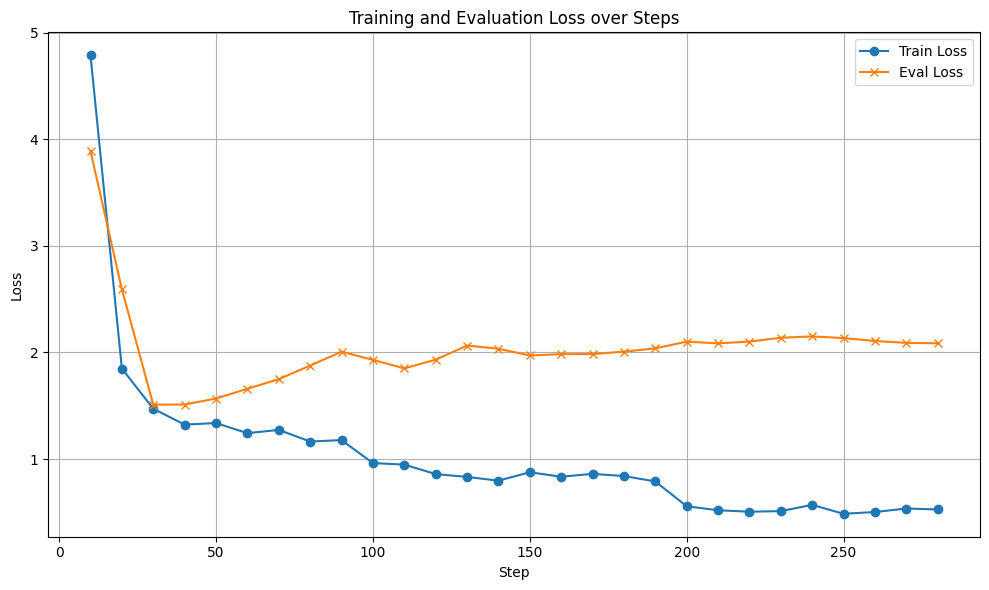

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training log file
file_path = "training_log.txt"

# Read the file into a DataFrame
data = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        step = int(parts[0])
        train_loss = None if parts[1] == "None" else float(parts[1])
        eval_loss = None if parts[2] == "None" else float(parts[2])
        data.append((step, train_loss, eval_loss))

df = pd.DataFrame(data, columns=["Step", "Train Loss", "Eval Loss"])

# Pivot to get clean columns
train_loss_df = df.dropna(subset=["Train Loss"])
eval_loss_df = df.dropna(subset=["Eval Loss"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss_df["Step"], train_loss_df["Train Loss"], label="Train Loss", marker='o')
plt.plot(eval_loss_df["Step"], eval_loss_df["Eval Loss"], label="Eval Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()